# Presentation

In [8]:
# import dependencies
import sys
import os
import cv2
from IPython.display import display, clear_output
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import keyboard
from fastai.vision.all import *
from pathlib import Path
from matplotlib import pyplot as plt
import torch

In [9]:
# Define the project paths
project_dir = Path(os.getcwd()).resolve().parent
model_dir = project_dir / 'Model'
data_dir = project_dir / 'Data'

sys.path.append(str(project_dir / '1_HaGRID'))
sys.path.append(str(project_dir / '2_Modelling' / 'Transforms'))

import constants
from Transforms import *


In [3]:
# Define Model
def get_model(model_type, setup, num_classes):
    if model_type == 'resnet34':
        model = resnet34(weights=ResNet34_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_type == 'vit':
        model = create_model("vit_base_patch16_224", pretrained=True)
        model.head = nn.Linear(model.head.in_features, num_classes)

    # If model already exists, load it
    if (model_dir / f"{model_type}_{setup}_best.pth").exists():
        print("Loading existing model...")
        model.load_state_dict(torch.load(model_dir / f"{model_type}_{setup}_best.pth", weights_only=True))

    return model


In [5]:
from ultralytics import YOLO

# Load a pre-trained YOLOv10n model
modelYOLO = YOLO("./../Model/YOLOv10x_hands.pt")
modelResNet = get_model('resnet34', 'frozen', len(constants.targets))

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\minem\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading existing model...


In [6]:
def draw_rectangle(frame, startXY, endXY, color=(0, 255, 0), thickness=2, text=""):
    y = startXY[1] - 10 if startXY[1] - 10 > 10 else startXY[1] + 10
    cv2.rectangle(frame, startXY, endXY, color, thickness)
    cv2.putText(frame, text, (startXY[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


0: 480x640 1 grabbing, 353.6ms
Speed: 3.5ms preprocess, 353.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
torch.Size([1, 3, 224, 224])
tensor([[0.0287, 0.0285, 0.0285, 0.0286, 0.0289, 0.0294, 0.0286, 0.0285, 0.0286, 0.0285, 0.0318, 0.0297, 0.0286, 0.0286, 0.0286, 0.0289, 0.0292, 0.0285, 0.0308, 0.0322, 0.0287, 0.0320, 0.0288, 0.0316, 0.0291, 0.0286, 0.0300, 0.0293, 0.0288, 0.0288, 0.0286, 0.0300, 0.0301, 0.0316]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 34])
tensor([0.1207], grad_fn=<IndexBackward0>)
19
one


C:\Users\minem\AppData\Local\Temp\ipykernel_29976\2910469404.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int(pred))
C:\Users\minem\AppData\Local\Temp\ipykernel_29976\2910469404.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(constants.targets[int(pred)])


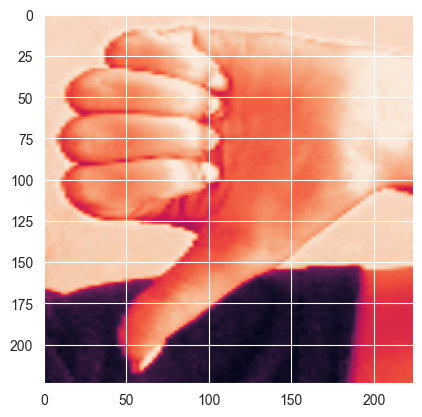

In [10]:
import numpy as np
from torchvision.transforms import v2
from torchvision.transforms.functional import crop
import torch

#img = cv2.imread('Images/ImageFist.jpg')
img = cv2.imread(data_dir / 'HaGRIDv2_dataset_512' / 'dislike' / '000ab30b-d977-4e0e-900c-34863ac5db94.jpg')
rgb_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = Image.fromarray(rgb_frame)

results = modelYOLO(img)

cropped_image = v2.ToImage()(img)

for result in results:
    for detection in result.boxes:
        # Crop the image using the bounding box
        x1, y1, x2, y2 = detection.xyxy[0].tolist()
        width = x2 - x1
        height = y2 - y1
        cropped_image = crop(img, top=y1, left=x1, height=height, width=width)
        # scale the image to 224x224
        cropped_image = v2.Resize((224, 224))(cropped_image)
        cropped_image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(cropped_image)
        cropped_image = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(cropped_image)
        #print(cropped_image.size)
        plt.imshow(cropped_image[0])
        #print(cropped_image.unsqueeze(int(0)))
        print(cropped_image.unsqueeze(int(0)).shape)

        preds = modelResNet(cropped_image.unsqueeze(int(0)))
        y_pred = torch.argmax(preds, dim=1).cpu().numpy()
        y_true = targs.cpu().numpy()
        
        #print(model_out)
        #print(pred)
        print(model_out.shape)
        model_out_max = model_out[0, pred]
        print(model_out_max)
        print(int(pred))
        print(constants.targets[int(pred)])
        plt.show()


In [39]:
# load a jpg image
img = cv2.imread('Images/ImageFist.jpg')
rgb_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = Image.fromarray(rgb_frame)

results = modelYOLO(img)

# Draw bounding boxes on the frame
draw = ImageDraw.Draw(img)

for result in results:
    for detection in result.boxes:
        # Get the bounding box coordinates and class
        x1, y1, x2, y2 = detection.xyxy[0].tolist()  # Bounding box corners
        croppedImage = image_net_transform(img, x1, y1, x2, y2)
        # plot the
        display(croppedImage[0,0])
        class_name = modelResNet(croppedImage)  # Detected class name
        model_pred = torch.argmax(class_name, dim=1).cpu().numpy()
        # tensor to int
        pred = int(model_pred[0])

        class_name = constants.targets[pred]

        # Draw the bounding box and label
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
        draw.text((x1, y1 - 10), class_name, fill="red", font=ImageFont.truetype("arial.ttf", 20))  # Draw class label

#display(img)


0: 640x480 1 grabbing, 618.7ms
Speed: 5.9ms preprocess, 618.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


NameError: name 'image_net_transform' is not defined

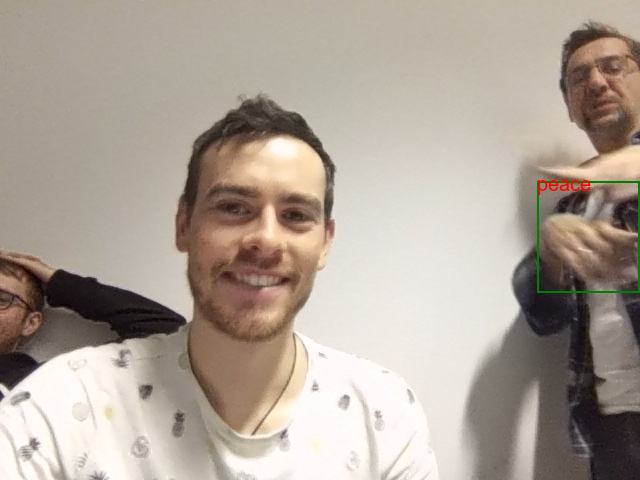


Stopped manually.


In [49]:
# Open the video capture (camera)
cap = cv2.VideoCapture(0)
image_net_transform = BBoxtoImageNet()

if not cap.isOpened():
    print("Error: Could not open video stream.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()

            # If frame was not captured correctly, break the loop
            if not ret:
                print("Failed to grab frame.")
                break

            # Convert frame (BGR to RGB)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw a rectangle on the frame
            #draw_rectangle(rgb_frame, (100, 100), (200, 200), text="Hand")

            # Convert to Image for display in Jupyter
            img = Image.fromarray(rgb_frame)

            # Perform object detection on the frame using YOLO
            results = modelYOLO(img)

            # Draw bounding boxes on the frame
            draw = ImageDraw.Draw(img)

            for result in results:
                for detection in result.boxes:
                    # Get the bounding box coordinates and class
                    x1, y1, x2, y2 = detection.xyxy[0].tolist()  # Bounding box corners
                    croppedImage = image_net_transform(img, x1, y1, x2, y2)
                    class_name = modelResNet(croppedImage)  # Detected class name
                    model_pred = torch.argmax(class_name, dim=1).cpu().numpy()
                    # tensor to int
                    pred = int(model_pred[0])

                    class_name = constants.targets[pred]

                    # Draw the bounding box and label
                    draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
                    draw.text((x1, y1 - 10), class_name, fill="red", font=ImageFont.truetype("arial.ttf", 20))  # Draw class label


            # Clear previous output and display the current frame
            clear_output(wait=True)
            display(img)

            # Check for 'q' key press to stop the loop
            if keyboard.is_pressed('q'):
                print("Key 'q' pressed. Exiting.")
                break
    except KeyboardInterrupt:
        print("Stopped manually.")
    finally:
        # Release the capture object
        cap.release()
        cv2.destroyAllWindows()